## Walmart sales - machine learning models

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from plotnine import *

from IPython.display import display
from tqdm import tqdm_notebook as tqdm

from datetime import datetime, timedelta

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style("whitegrid")

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

In [6]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

### Dataframes

In [7]:
df = pd.read_csv('data/processed/all.csv')

df['Date'] = pd.to_datetime(df['Date'])

holidays = sorted(df.query('IsHoliday==True').DateString.unique())
stores = sorted(df.Store.unique())

### Models

We'll build simple machine learning models that predict the sales increase from last year

DummyRegressor MAE=968.911736264 WMAE=268.086608696 RMSE=1560.54524279


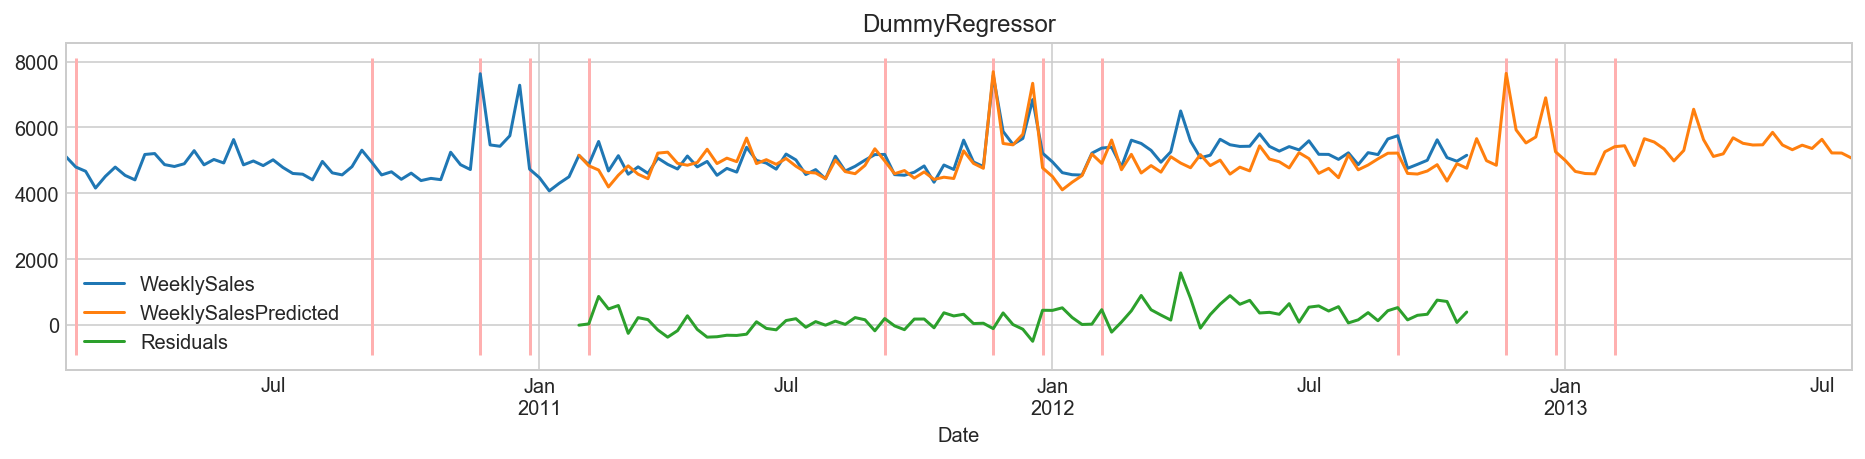

LinearRegression MAE=958.338514587 WMAE=339.069920878 RMSE=1560.69504032


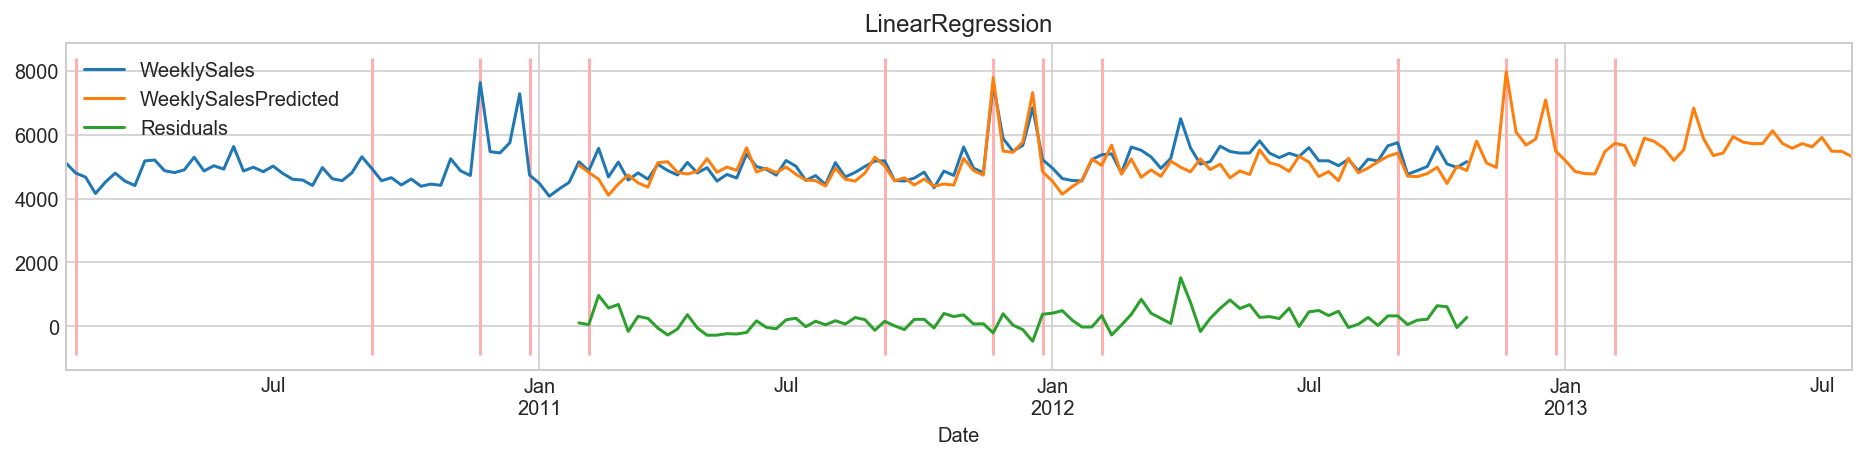

ElasticNet MAE=976.746995611 WMAE=297.380816549 RMSE=1575.80824063


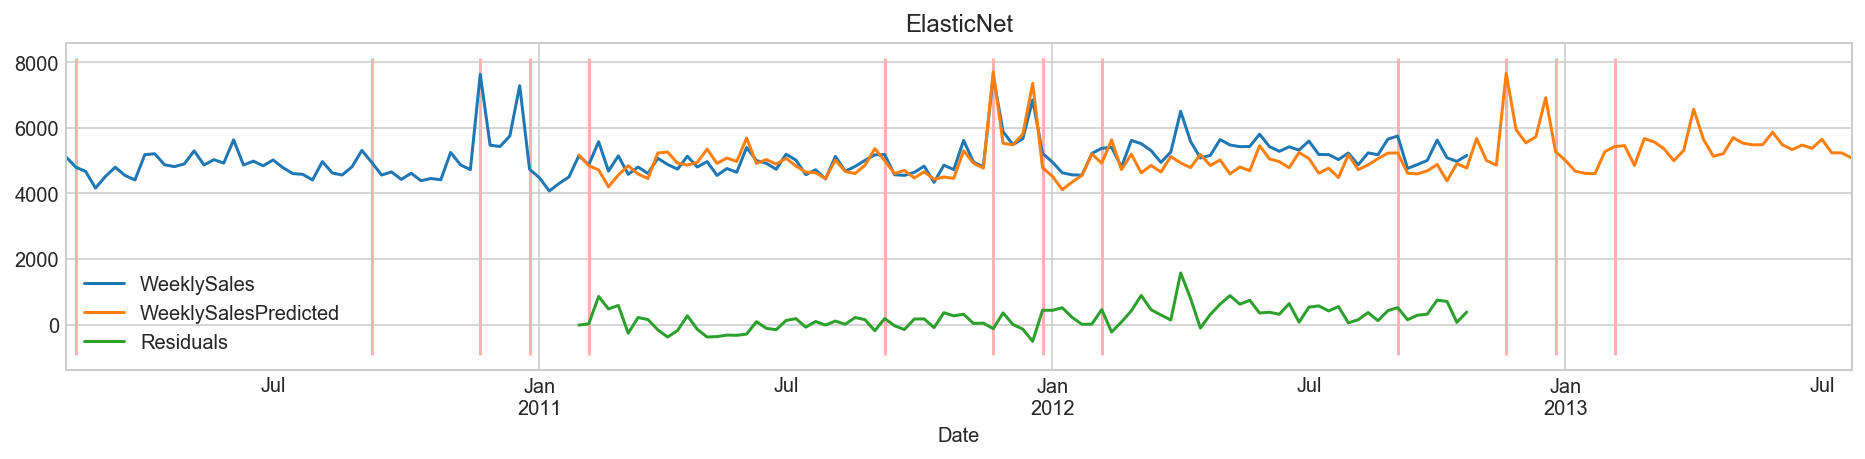

RandomForestRegressor MAE=973.563346465 WMAE=581.951317972 RMSE=1551.98531688


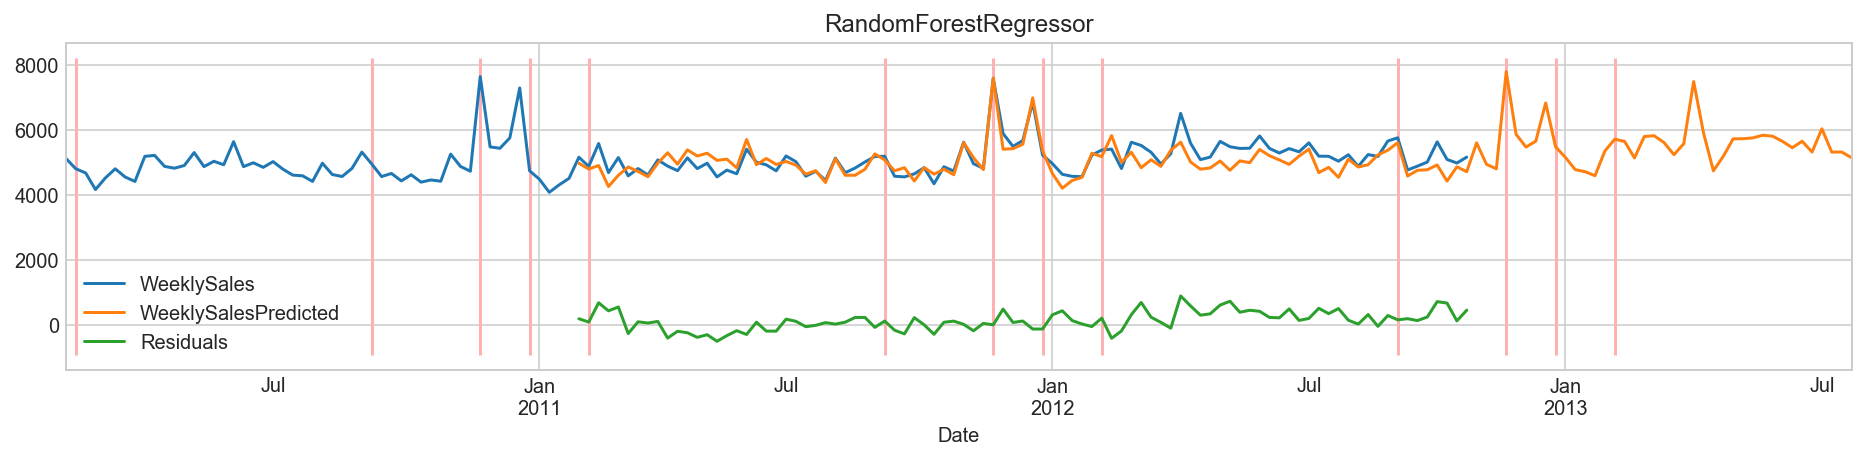

XGBRegressor MAE=947.439517721 WMAE=372.536335958 RMSE=1547.90146064


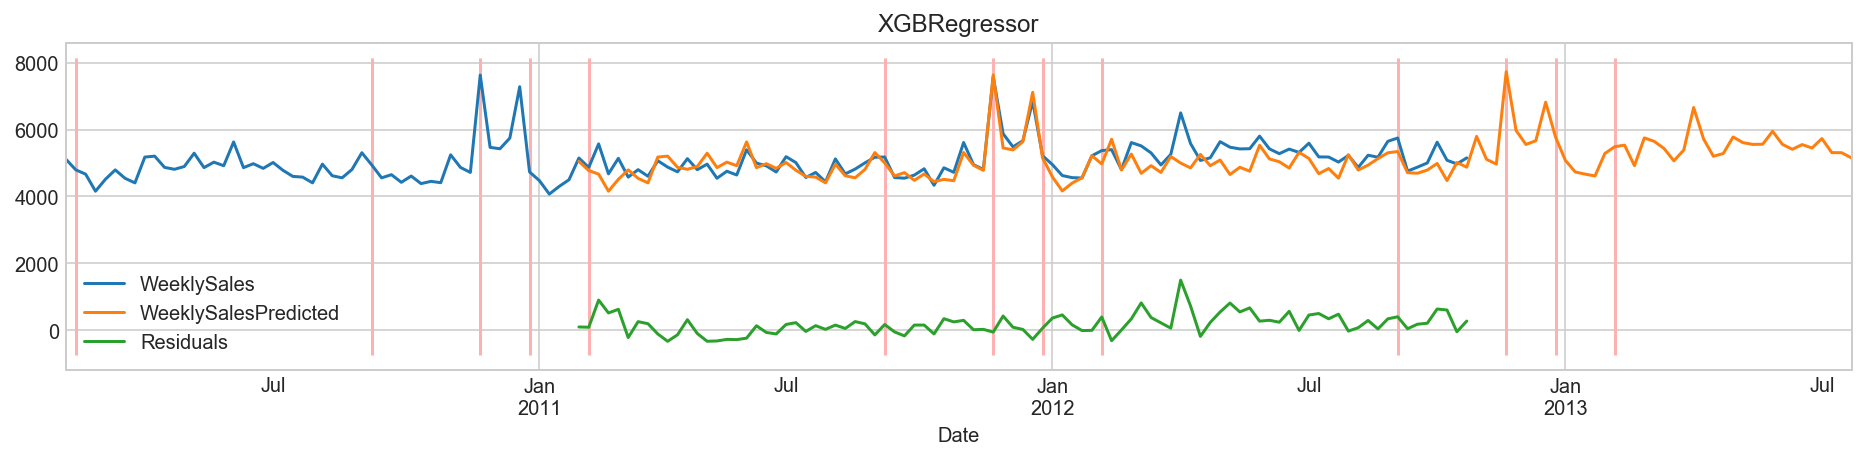

SVR MAE=909.444675162 WMAE=289.219477387 RMSE=1490.60215104


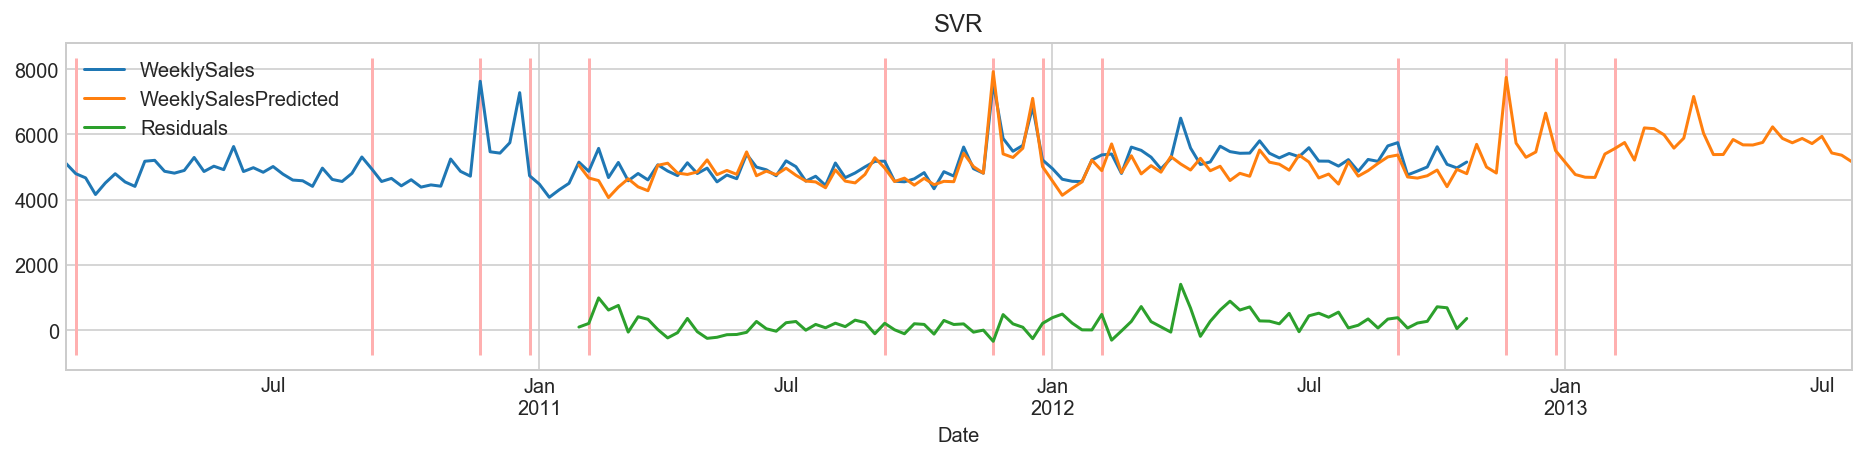

In [8]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
import random

train_stores = random.sample(stores, int(len(stores)*0.75))
test_stores = [s for s in stores if s not in train_stores]

def forecast(regressor, train_start="2011-05", train_end="2012-43", forecast_start="2012-44"):
    
    store_dummies = ['Store_%s'%i for i in sorted(df.Store.unique())]
    features = ['Year', 'Week', 'IsHoliday'] + store_dummies
    
    # perform training on the training set
    
    df_train = df[(df.YearWeek>=train_start) & (df.YearWeek<=train_end) & (df.Store.isin(train_stores))]
    
    X = df_train[features].values
    y = df_train['WeeklySalesIncreaseRatio'].values
    regressor.fit(X,y)
    
    # perform predictions on the test set
    
    dff = df[df.Store.isin(test_stores)].copy()
    
    pred_idx = (dff.YearWeek>=train_start) 
    df_pred = dff[pred_idx]

    X_pred = df_pred[features].values
    y_pred = regressor.predict(X_pred)

    dff.loc[pred_idx, 'WeeklySalesIncreaseRatioPredicted'] = y_pred    
    dff.loc[pred_idx, 'WeeklySalesPredicted'] = df_pred['WeeklySalesPreviousYear'] * y_pred
    dff.loc[pred_idx, 'Residuals'] = df_pred['WeeklySales'] - df_pred['WeeklySalesPreviousYear'] * y_pred
    
    # metrics
    
    dfm = dff[(dff.YearWeek>=train_start) & (dff.YearWeek<=train_end)]
    y_pred = dfm.WeeklySalesPredicted.values
    y_actual = dfm.WeeklySales.values
    w = dfm.IsHoliday.map(lambda v: 5 if v else 1).values

    rmse = np.sqrt(np.mean((y_pred-y_actual)**2))    
    wmae = np.sum(w*(y_pred-y_actual)) / np.sum(w)
    mae = np.mean(np.abs(y_pred-y_actual))
        
    return mae, wmae, rmse, dff

# 1.008 is the average WeeklySalesIncreaseRatio for all stores (see the exploratory notebook)
for reg in [DummyRegressor(strategy='constant', constant=1.008),  LinearRegression(), ElasticNet(), RandomForestRegressor(), XGBRegressor(), SVR()]:
    
    name = type(reg).__name__

    mae, wmae, rmse, dff = forecast(reg)
    print("%s MAE=%s WMAE=%s RMSE=%s" % (name, mae, wmae, rmse))

    ax  = dff[dff.Store==test_stores[0]].plot(x='Date', y=['WeeklySales','WeeklySalesPredicted', 'Residuals'], figsize=(16,3), title=name)
    ymin, ymax = ax.get_ylim()
    ax.vlines(x=holidays, ymin=ymin, ymax=ymax-1, color='#ffb0b0')
    plt.show()